# Quick Draw Neural Network

The [Quick Draw Dataset](https://quickdraw.withgoogle.com/data) is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The drawings were captured as timestamped vectors, tagged with metadata including what the player was asked to draw and in which country the player was located.

In this notebook I attempt to create a Deep Learning Neural Network to classify the drawings.

After building the model I will build a web applicationt to implement this into [safoan.me](https://www.safoan.me)

## Data Processing
For this project I will make use of the `.npy` Numpy Bitmaps which on top of the simplification:
1. Align the drawing to the top-left corner, to have minimum values of 0.
2. Uniformly scale the drawing, to have a maximum value of 255.
3. Resample all strokes with a 1 pixel spacing.
4. Simplify all strokes using the Ramer–Douglas–Peucker algorithm with an epsilon value of 2.0.

Have also been redered in 28x28 gray scale images into numpy `.npy` format, while also being re-aligned to the center of the drawing bounding box. Due to this being pre-processed it makes it easier to work with.

**Metric** used will be **Accuracy** as the primary goal is to correctly guess as many as possible.

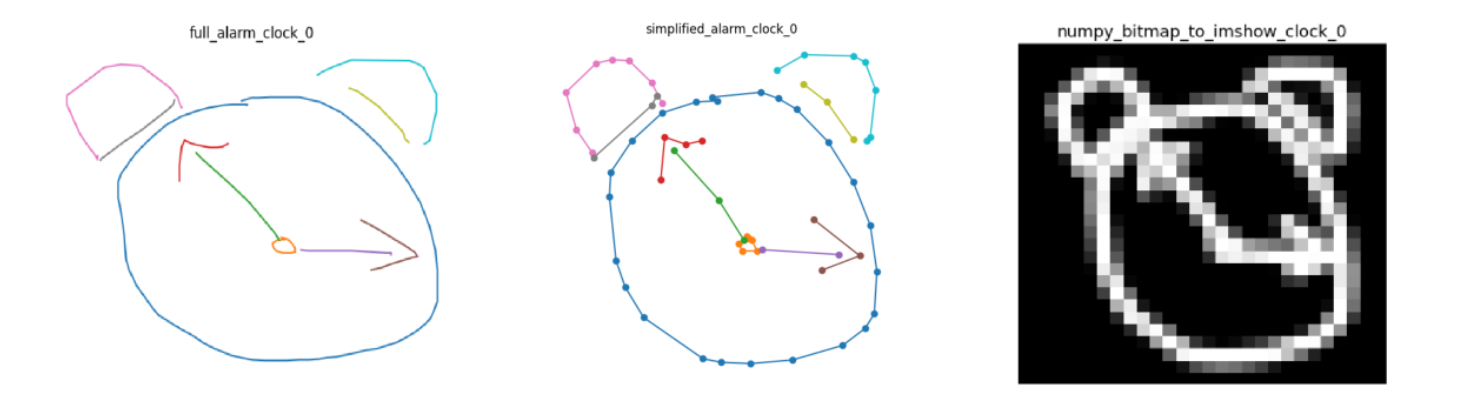

**Install the numpy bitmap "images"**
```bash
    mkdir numpy_bitmap
    gsutil -m cp "gs://quickdraw_dataset/full/numpy_bitmap/*.npy" numpy_bitmap
```

In [63]:
import os
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from scipy.ndimage import rotate

For I notice the file names arent standardised, some with capitals, some with spaces so ill begin with that.

Then for runtimes for now I'll only work with 10 categories, as opposed to the total 345. This reduces the data from 50,000,000+ bitmaps.

In [64]:
IMAGES_DIR = "numpy_bitmap/"

# standardize filenames
# for filename in os.listdir(IMAGES_DIR):
#     os.rename(IMAGES_DIR + filename, IMAGES_DIR + filename.replace(" ", "_").lower())

cat_a = os.listdir(IMAGES_DIR)
print(f'Total categories: {len(cat_a)} \nAll categories: {cat_a}')

cat_s = cat_a[12:32]
print(f'Sample categories: {cat_s}')

Total categories: 345 
All categories: ['arm.npy', 'bench.npy', 'the_eiffel_tower.npy', 'diving_board.npy', 'baseball_bat.npy', 'bottlecap.npy', 'mailbox.npy', 'calendar.npy', 'aircraft_carrier.npy', 'animal_migration.npy', 'cello.npy', 'bowtie.npy', 'dog.npy', 'axe.npy', 'bat.npy', 'alarm_clock.npy', 'backpack.npy', 'blueberry.npy', 'elephant.npy', 'broom.npy', 'cruise_ship.npy', 'beard.npy', 'ant.npy', 'the_mona_lisa.npy', 'barn.npy', 'cat.npy', 'oven.npy', 'bear.npy', 'bracelet.npy', 'bed.npy', 'basket.npy', 'bee.npy', 'belt.npy', 'baseball.npy', 'car.npy', 'bird.npy', 'birthday_cake.npy', 'apple.npy', 'circle.npy', 'bandage.npy', 'door.npy', 'anvil.npy', 'book.npy', 'blackberry.npy', 'basketball.npy', 'bathtub.npy', 'ambulance.npy', 'bridge.npy', 'asparagus.npy', 'clarinet.npy', 'eyeglasses.npy', 'airplane.npy', 'brain.npy', 'angel.npy', 'broccoli.npy', 'banana.npy', 'clock.npy', 'the_great_wall_of_china.npy', 'helicopter.npy', 'binoculars.npy', 'cloud.npy', 'beach.npy', 'dumbbell.

In [65]:
# add all drawings into a dataframe
bmap_split = pd.DataFrame()
bmap = pd.DataFrame()
bitmaps = []

for category in cat_s:
    data = pd.DataFrame(np.load(IMAGES_DIR + category))
    data["category"] = category
    bitmaps.append(data)
    
bmap_split = pd.concat(bitmaps, ignore_index=True)
bmap_split.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,category
1909002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,oven.npy
1889904,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,oven.npy
1130426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,cruise_ship.npy
852867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,elephant.npy
687015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,blueberry.npy


In [66]:
bmap["y"] = bmap_split["category"].apply(lambda x: x.split(".")[0])
bmap["X"] = bmap_split.iloc[:, :-1].apply(lambda x: np.array(x).reshape(28,28), axis=1)

### Visualizations
Using `matplotlib`

In [67]:
def show_images(df, n_images, category=None):
    
    '''
    Converting n_images of bitmap arrays into images
    
    parameters:
    df: dataframe with X and y columns, 
        X: bitmap array
        y: category label
    n_images: number of images to display
    
    output: figure with n_images labelled
    return: none
    '''
    fig_h = 1.5 * (n_images//10) # height of the figure
    fig, axs = plt.subplots(n_images//10, 10, figsize=(12, fig_h))
    axs = axs.flatten() # 2D - 1D to make it simpler to iterate trough, eg: ax[0,0] -> ax[0]
    
    if not category:
        sample = df.sample(n_images)
    else:
        sample = df[df['y'] == category].sample(n_images)
    
    label = sample['y'].values
    image = sample['X'].values
    
    for n in range(n_images):
        axs[n].imshow(image[n])
        axs[n].set_title(label[n])
        axs[n].axis('off')
    
    plt.tight_layout()
    plt.show()

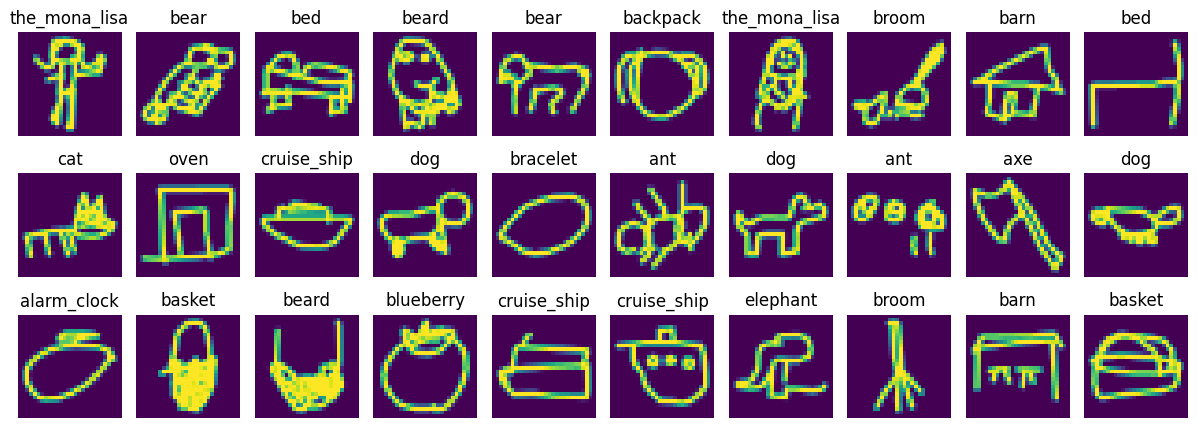

In [68]:
show_images(bmap, 30)

It'll also be interesting seeing images from each category overlayed on top of eachother as a heatmap, this will give a general understanding of the way people interpret cetain objects as some may interpret some objects to have multiple meanings.
* Ex: bat -> baseball bat, animal bat, cricket bat, etc.


Or some may also draw the same objects differently
* Ex: Orientations, style

To achieve this, I'll stack each image on top of each other then squeeze back into 2D

In [69]:
def category_heatmap(df):
    '''
    Overlaying bitmaps of different category to create a heatmap
    
    parameters: 
    df: dataframe with X and y columns
    
    output: categorical heatmaps
    returns: none
    '''
    
    categories = df['y'].unique()
    n_cat = len(categories)
    
    fig_h = 1.5 * (n_cat//3)
    fig, axs = plt.subplots(n_cat//5, 5, figsize=(10, fig_h))
    axs = axs.flatten()
    
    for n in range(n_cat):
        arrs = df[df['y'] == categories[n]]['X']
        heatmap = np.stack(arrs).sum(axis=0)
      
        axs[n].imshow(heatmap)
        axs[n].set_title(categories[n])
        axs[n].axis('off')
        
    plt.tight_layout()
    plt.show()

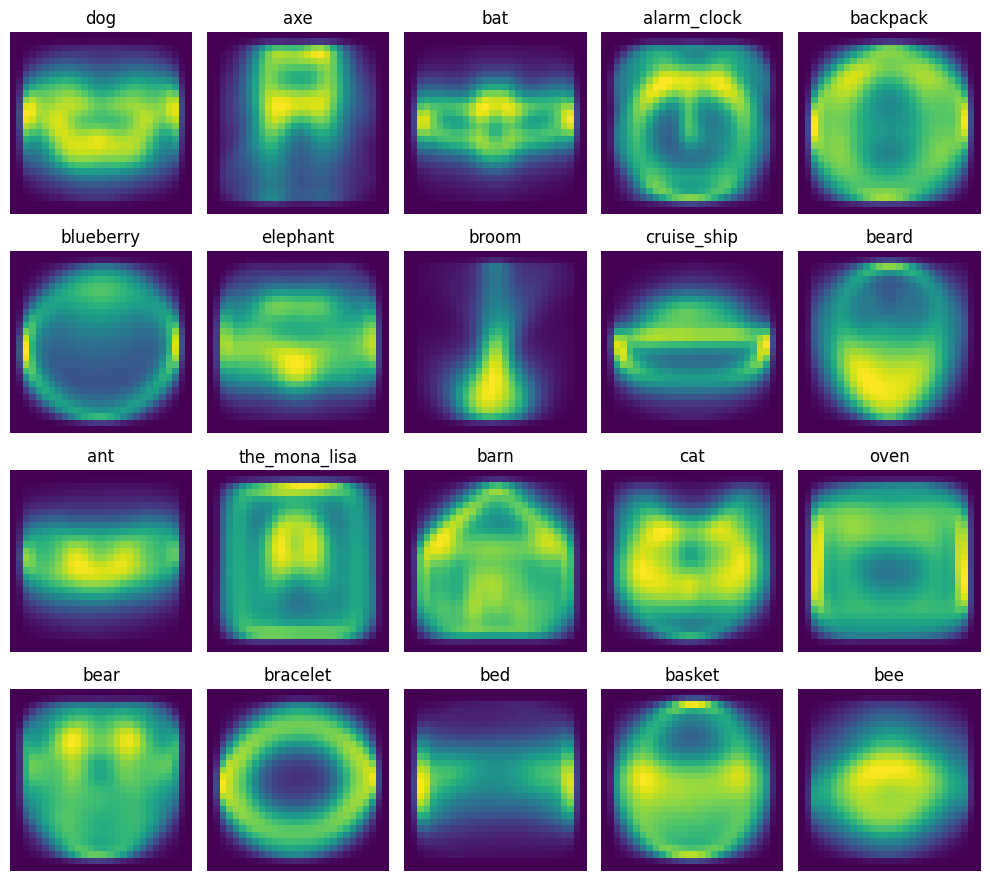

In [70]:
category_heatmap(bmap)

A few examples of things that we can infer about the people who partook in making the drawings.
* Bat is mostly interpreted as the animal
* Broom is mostly drawn as being upright
* Alarm clock is mostly interpreted as an analog one

### Aurgmenting dataset
Add sensible variation by "generating" more images based on the images already present
* Rotating: +-15 deg [scipy.ndimage rotate]
* Flipping: horizontal and vertical

*In this example to keep the dataframe size still managable for myself I'll only flip it horizontally once.*

This improves **generalization** while reducing **overfitting** and **variation**.

Depending on the representation of each category i might decide to further aurgment specific categories

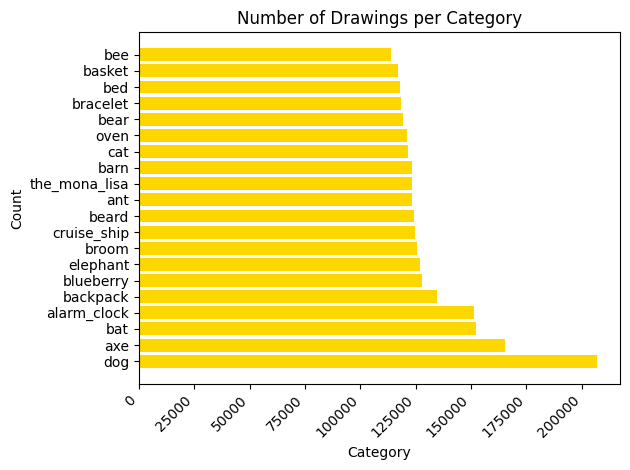

In [71]:
plt.barh(bmap['y'].unique(), bmap['y'].value_counts(), color='gold')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Number of Drawings per Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [72]:
bmap[bmap['y'] == 'alarm_clock']['X']

394395    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
394396    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
394397    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
394398    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
394399    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
                                ...                        
517789    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
517790    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
517791    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
517792    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
517793    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: X, Length: 123399, dtype: object

Text(0.5, 1.0, 'Flip Vertical')

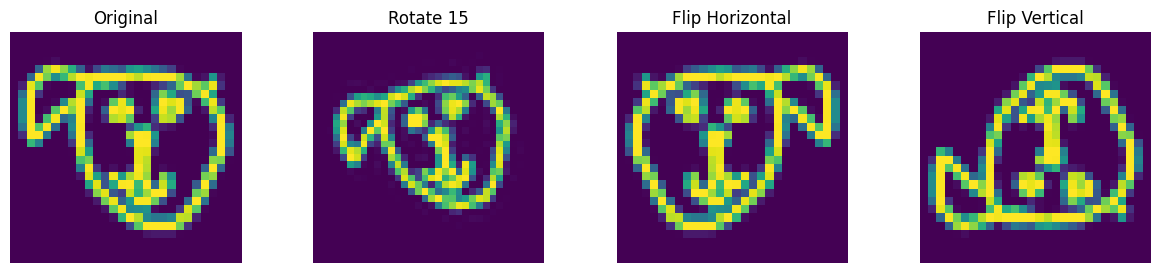

In [73]:
# emaple
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
[ax.axis('off') for ax in axs]
image = bmap.iloc[0, 1]

axs[0].imshow(image)
axs[0].set_title('Original')

axs[1].imshow(rotate(image, 15))
axs[1].set_title('Rotate 15')

axs[2].imshow(image[:,::-1])
axs[2].set_title('Flip Horizontal')

axs[3].imshow(image[::-1,:])
axs[3].set_title('Flip Vertical')

Text(0.5, 1.0, 'Flip Vertical')

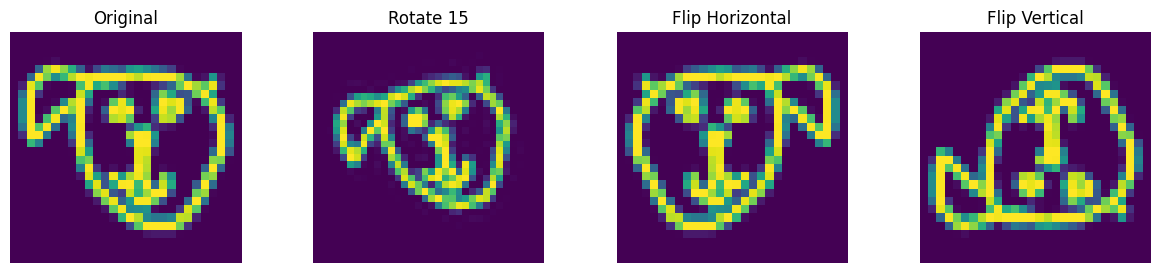

In [74]:
# emaple
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
[ax.axis('off') for ax in axs]
image = bmap.iloc[0, 1]

axs[0].imshow(image)
axs[0].set_title('Original')

axs[1].imshow(rotate(image, 15))
axs[1].set_title('Rotate 15')

axs[2].imshow(image[:,::-1])
axs[2].set_title('Flip Horizontal')

axs[3].imshow(image[::-1,:])
axs[3].set_title('Flip Vertical')

In [75]:
bmap_hflip = bmap.copy()
bmap_hflip['X'] = bmap_hflip['X'].apply(lambda x: x[:, ::-1])

bmap = pd.concat([bmap, bmap_hflip], axis=0).reset_index(drop=True)